In [21]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime


In [22]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', '^GSPC']

# We would like all available data from 10 month back (approx ~) 

# end_date = datetime.datetime(2019, 10,19)
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=(30 * 10))

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
df = data.DataReader('AAPL', 'yahoo', start_date, end_date)

In [23]:
df.shape

(207, 6)

In [24]:
close = df['Close']
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
# all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
# close = close.reindex(all_weekdays)
# close = close.fillna(method='ffill')

In [25]:
close.head(10)

Date
2019-04-30    200.669998
2019-05-01    210.520004
2019-05-02    209.149994
2019-05-03    211.750000
2019-05-06    208.479996
2019-05-07    202.860001
2019-05-08    202.899994
2019-05-09    200.720001
2019-05-10    197.179993
2019-05-13    185.720001
Name: Close, dtype: float64

In [26]:
plt.style.available

['bmh',
 'classic',
 'dark_background',
 'seaborn',
 'seaborn-talk',
 'seaborn-dark-palette',
 '_classic_test',
 'seaborn-dark',
 'seaborn-muted',
 'seaborn-poster',
 'seaborn-darkgrid',
 'seaborn-pastel',
 'seaborn-deep',
 'fivethirtyeight',
 'seaborn-colorblind',
 'Solarize_Light2',
 'seaborn-white',
 'grayscale',
 'seaborn-bright',
 'seaborn-notebook',
 'ggplot',
 'fast',
 'seaborn-paper',
 'tableau-colorblind10',
 'seaborn-ticks',
 'seaborn-whitegrid']

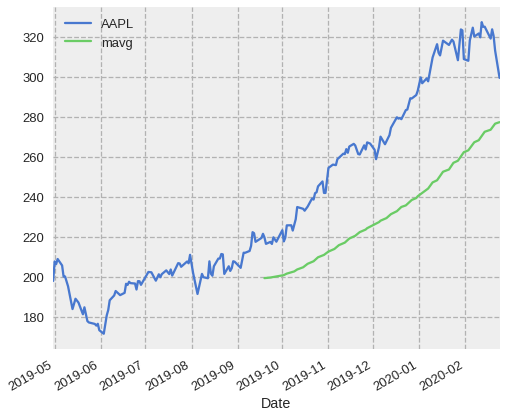

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
# style.use('seaborn-dark')
plt.tight_layout()
plt.style.use(['fast', 'seaborn-muted'])


close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [29]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-04-30,198.077362,46534900.0,2.137835,-1.176992
2019-05-01,207.800110,64827300.0,2.888087,0.304936
2019-05-02,206.447800,31996300.0,2.161123,-0.328823
2019-05-03,209.014221,20892400.0,0.760331,0.407796
2019-05-06,205.786469,32443100.0,2.561395,2.051007


In [30]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
# forecast_out = int(math.ceil(0.1 * len(dfreg)))
forecast_out =60

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)
# dfreg.head(5)
X_lately.shape
# dfreg.head()

(207, 4)
Dimension of X (147, 4)
Dimension of y (147,)


(60, 4)

In [31]:
forecast_out

60

In [32]:
# Temp Space
int(math.ceil(0.001 * len(dfreg)))

1

In [33]:
# Separation of training and testing of model by cross validation train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)


# # Quadratic Regression 2
# clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
# clfpoly2.fit(X_train, y_train)

# # Quadratic Regression 3
# clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
# clfpoly3.fit(X_train, y_train)
    
# # KNN Regression
# clfknn = KNeighborsRegressor(n_neighbors=2)
# clfknn.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [35]:
# confidencereg = clfreg.score(X_test, y_test)
# confidencepoly2 = clfpoly2.score(X_test,y_test)
# confidencepoly3 = clfpoly3.score(X_test,y_test)
# confidenceknn = clfknn.score(X_test, y_test)

# print("The linear regression confidence is ",confidencereg)
# print("The quadratic regression 2 confidence is ",confidencepoly2)
# print("The quadratic regression 3 confidence is ",confidencepoly3)
# print("The knn regression confidence is ",confidenceknn)

In [36]:
# Printing the forecast
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
# print(forecast_set, confidencereg, forecast_out)

In [37]:
# dfreg.iloc[250].name
dfreg.columns
# X_lately.iloc[-1].name

Index(['Adj Close', 'Volume', 'HL_PCT', 'PCT_change', 'label', 'Forecast'], dtype='object')

In [38]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
#     print(next_date)
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
     

In [39]:
# dfreg.iloc[260]
# len(dfreg)
# forecast_set
dfreg.tail(155)

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2019-10-08,223.198593,27955000.0,1.662208,-0.628825,296.725769,NaN
2019-10-09,225.814514,18692600.0,0.947009,0.000000,299.090149,NaN
2019-10-10,228.858124,28253400.0,1.364683,0.947661,297.683533,NaN
2019-10-11,234.945358,41698900.0,2.256467,1.399446,302.472137,NaN
2019-10-14,234.607178,24106900.0,1.466913,0.412942,308.896912,NaN
...,...,...,...,...,...,...
2020-04-20,NaN,NaN,NaN,NaN,NaN,421.145916
2020-04-21,NaN,NaN,NaN,NaN,NaN,432.733561
2020-04-22,NaN,NaN,NaN,NaN,NaN,433.914076


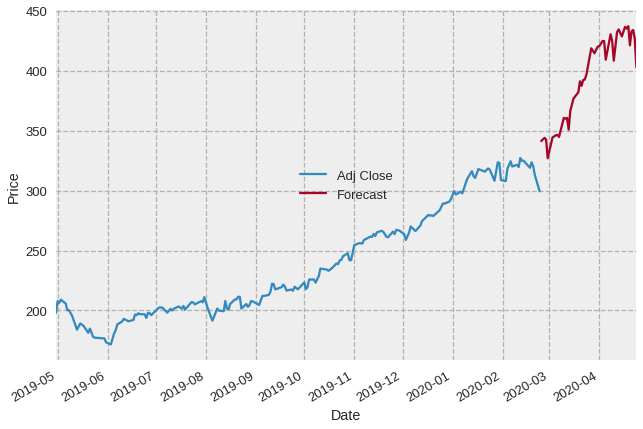

In [40]:
dfreg['Adj Close'].plot()
dfreg['Forecast'].plot()
plt.legend(loc=10)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()